# Libraries & Setup

In [32]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D, GRU, SimpleRNN, LSTM
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib 
import os
import io
import json
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import spacy # for text encoding
from spacy.lang.en.stop_words import STOP_WORDS

#!python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md')

warnings.filterwarnings('ignore')

# Dataset loading

In [17]:
# Import dataset
print("Loading dataset...")
df = pd.read_csv("./assets/spam.csv", encoding='ANSI')  # sep = ";"
pd.set_option('display.max_columns', None)
print("...Done.")
print()

Loading dataset...
...Done.



In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [19]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")

pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

Number of rows : 5572

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


,Missing Records,Percentage (%)
v1,0,0.000000
v2,0,0.000000
Unnamed: 2,5522,99.102656
Unnamed: 3,5560,99.784637
Unnamed: 4,5566,99.892319


Nous avons "ham" qui représente de bons messages et nous avons du "spam" qui représente des messages indésirables.

# Data Cleaning et Viz

In [20]:
# Les colonnes 2, 3, 4 ont des valeurs manquantes majoritaires, il est donc préférable de les supprimer.
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [21]:
# On renomme les noms de colonne
df.rename(columns = {'v1':'result', 'v2':'input'}, inplace=True)

In [22]:
pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

,Missing Records,Percentage (%)
result,0,0.0
input,0,0.0


In [23]:
df.sample(5)

,result,input
2936,ham,Lol yep did that yesterday. Already got my fir...
2143,ham,You stayin out of trouble stranger!!saw Dave t...
465,ham,great princess! I love giving and receiving or...
5208,ham,Hi.what you think about match?
39,ham,Hello! How's you and how did saturday go? I wa...


In [24]:

#checking the number of SPAM vs not SPAM messages
df['result'].value_counts()

result
ham     4825
spam     747
Name: count, dtype: int64

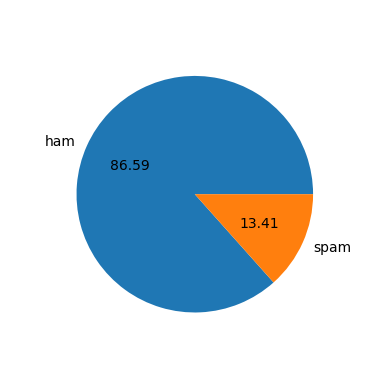

In [25]:
# réprésentation graphique

plt.pie(df['result'].value_counts(),  labels = ['ham', 'spam'], autopct = '%0.2f', radius = 0.8)
plt.show()

# Preprocessing

### 1. Text formating

In [29]:
# On nettoie les textes envoyés "input", en enlevant les caractères spéciaux, les espaces en trop, et les majuscules et en categorisant le resultat 0/1

df["target"] = df["result"].apply(lambda x : 1 if x == "spam" else 0)
df["input_cleaned"] = df["input"].apply(lambda x : ''.join(ch for ch in x if ch.isalnum() or ch==" "))
df["input_cleaned"] = df["input_cleaned"].apply(lambda x: x.replace("  "," ").lower().strip())
print("Processing...")
df.sample(5)

Processing...


,result,input,target,input_cleaned
2700,ham,"Feb &lt;#&gt; is \I LOVE U\"" day. Send dis t...",0,feb ltgt is i love u day send dis to all ur va...
2806,spam,December only! Had your mobile 11mths+? You ar...,1,december only had your mobile 11mths you are e...
1922,ham,I'll be in sch fr 4-6... I dun haf da book in ...,0,ill be in sch fr 46 i dun haf da book in sch i...
4442,ham,You know my old Dom I told you about yesterday...,0,you know my old dom i told you about yesterday...
4182,ham,"Sorry, I'll call later in meeting",0,sorry ill call later in meeting


### 2. Lemnatization

In [33]:
# Lemmatisation grâce à spacy, adapté au vocabulaire "web", de taille medium :
# La lemmatisation est un processus linguistique qui transforme un mot en sa forme de base ou "lemma". Par exemple, les mots "running", "runs", et "ran" sont tous transformés en leur lemma "run" lors de la lemmatisation. Cela aide à réduire la complexité du texte pour l'analyse, en regroupant ensemble les différentes formes d'un même mot.
df["input_lemnatized"] = df["input_cleaned"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
df.sample(5)

,result,input,target,input_cleaned,input_lemnatized
1487,ham,I told your number to gautham..,0,i told your number to gautham,tell number gautham
3253,ham,I can make lasagna for you... vodka...,0,i can make lasagna for you vodka,lasagna vodka
2701,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",0,hiya sorry didnt hav signal i havent seen or h...,hiya sorry hav signal hear unusual ill case so...
1856,ham,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",0,say this slowly godi love you amp i need youcl...,slowly godi love amp need youclean heart blood...
4222,ham,Stupid auto correct on my phone,0,stupid auto correct on my phone,stupid auto correct phone


### 3. Tokenization

In [34]:
# La tokenisation est une étape clé du prétraitement du texte dans le domaine du traitement du langage naturel (NLP). Elle consiste à diviser le texte en unités plus petites, appelées "tokens". Dans le contexte le plus courant, les tokens sont souvent des mots individuels

token = tf.keras.preprocessing.text.Tokenizer()
token.fit_on_texts(df["input_lemnatized"])
df["input_tokenized"] = token.texts_to_sequences(df["input_lemnatized"])
df.sample(5)

,result,input,target,input_cleaned,input_lemnatized,input_tokenized
90,ham,Yeah do! Don‰Û÷t stand to close tho- you‰Û÷ll ...,0,yeah do donût stand to close tho youûll catch ...,yeah donût stand close tho youûll catch,"[77, 1088, 665, 303, 449, 3661, 467]"
1409,ham,Where at were hungry too,0,where at were hungry too,hungry,[532]
3528,spam,Xmas & New Years Eve tickets are now on sale f...,1,xmas new years eve tickets are now on sale fro...,xma new year eve ticket sale club day 10 till ...,"[904, 37, 91, 415, 474, 825, 398, 16, 489, 328..."
804,ham,K I'll be there before 4.,0,k ill be there before 4,k ill 4,"[98, 17, 7]"
340,ham,Ok that's great thanx a lot.,0,ok thats great thanx a lot,ok s great thanx lot,"[9, 6, 52, 261, 135]"


In [35]:
df["input_len"] = df["input_tokenized"].apply(lambda x: len(x))

# remove empty text
df = df[df["input_len"]!=0]
display(df.sample(5))
df.shape

,result,input,target,input_cleaned,input_lemnatized,input_tokenized,input_len
5187,ham,WHAT TIME U WRKIN?,0,what time u wrkin,time u wrkin,"[18, 1, 7925]",3
211,ham,Home so we can always chat,0,home so we can always chat,home chat,"[25, 117]",2
19,spam,England v Macedonia - dont miss the goals/team...,1,england v macedonia dont miss the goalsteam ne...,england v macedonia miss goalsteam news txt ur...,"[711, 131, 3615, 44, 3616, 448, 24, 4, 610, 94...",19
2825,ham,Ok lor...,0,ok lor,ok lor,"[9, 26]",2
1132,ham,Good morning princess! How are you?,0,good morning princess how are you,good morning princess,"[12, 85, 254]",3


(5555, 7)

In [36]:
# on fait un le pading(pour transformer les séquences de nombres de la colonne "input_tokenized" en séquences de longueur fixe)
train_pad = tf.keras.preprocessing.sequence.pad_sequences(df["input_tokenized"], padding="post")
train_pad.shape

(5555, 72)

### 4. Spliting

In [37]:
xtrain, xval, ytrain, yval = train_test_split(train_pad, df["target"],
                                              test_size=0.2, random_state=0,
                                              stratify=df["target"])

train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_data = train.shuffle(len(train)).batch(64)
val_data = val.shuffle(len(val)).batch(64)

In [38]:
# Pour chaque target on affiche à côté la séquence que l'on a crée

for text_batch, label_batch in train_data.take(1):
  for i in range(5):
    print(label_batch[i].numpy(), text_batch.numpy()[i])

0 [ 173   71 1150 1120  381 1141  277   89   49   34  570    2 1140   45
   55  148   59  570   89  600   45  347  270  131  484    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
0 [  2 306  68 995  17  25  38 122   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
0 [   1 2698  184   17  108 5108 3061 5109    3  244    1    8    1   64
 5110 5111 5112 5113    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

# Modeling

In [39]:
embedding_dim=16 # la dimensionnalité de l'espace de représentation
vocab_size = len(token.word_counts) # Taille du vocabulaire et nombre de mots dans une séquence.
display(vocab_size)

8214

In [40]:
# Moyenne globale du Pooling
model_GAP = Sequential([
  Embedding(vocab_size+1, embedding_dim, name="embedding"), 
  GlobalAveragePooling1D(),
  Dense(32, activation='relu'),
  Dense(16, activation='relu'),
  Dense(2, activation="sigmoid") # Sigmoid nous garantit une sortie entre 0 et 1, Nous sommes dans le cas d'une classification binaire, donc cela semble être un bon choix
])

model_GAP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          131440    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 132546 (517.76 KB)
Trainable params: 132546 (517.76 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [41]:
# compilation du model 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
model_GAP.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [44]:
df

,result,input,target,input_cleaned,input_lemnatized,input_tokenized,input_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...,"[3602, 231, 445, 461, 941, 35, 52, 205, 942, 7...",14
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni,ok lar joke wif u oni,"[9, 194, 462, 288, 1, 1453]",6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 301, 3, 530, 658, 32, 1454, 844, 422, 145...",22
3,ham,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say,u dun early hor u c,"[1, 124, 148, 2363, 1, 83]",6
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah i dont think he goes to usf he lives aroun...,nah think usf live,"[704, 22, 659, 129]",4
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,this is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u u win å750 pound priz...,"[266, 18, 53, 3, 92, 1, 1, 32, 8209, 278, 69, ...",19
5568,ham,Will Ì_ b going to esplanade fr home?,0,will ì b going to esplanade fr home,ì b esplanade fr home,"[45, 108, 1537, 575, 25]",5
5569,ham,"Pity, * was in mood for that. So...any other s...",0,pity was in mood for that soany other suggestions,pity mood soany suggestion,"[8212, 936, 8213, 3598]",4
5570,ham,The guy did some bitching but I acted like i'd...,0,the guy did some bitching but i acted like id ...,guy bitching act like d interested buy week free,"[112, 8214, 1595, 14, 31, 1119, 86, 38, 11]",9


In [45]:
# model fitting

# get the apparition frequency for spam

spam_freq = pd.DataFrame(df["target"].value_counts())
spam_freq.columns = ['target']
spam_freq.sort_index(inplace=True)
class_weight = {v: (1 / spam_freq.loc[v,"target"]) / 2 * spam_freq["target"].sum() for v in spam_freq.index}


model_GAP.fit(
    train_data,
    validation_data=val_data,
    class_weight=class_weight,
    epochs=30)

Epoch 1/30
70/70 [==============================] - 1s 3ms/step - loss: 0.6898 - sparse_categorical_accuracy: 0.4377 - val_loss: 0.6717 - val_sparse_categorical_accuracy: 0.9307
Epoch 2/30
70/70 [==============================] - 0s 2ms/step - loss: 0.6471 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.5791 - val_sparse_categorical_accuracy: 0.9712
Epoch 3/30
70/70 [==============================] - 0s 2ms/step - loss: 0.4570 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.3078 - val_sparse_categorical_accuracy: 0.9757
Epoch 4/30
70/70 [==============================] - 0s 2ms/step - loss: 0.2115 - sparse_categorical_accuracy: 0.9863 - val_loss: 0.1496 - val_sparse_categorical_accuracy: 0.9766
Epoch 5/30
70/70 [==============================] - 0s 2ms/step - loss: 0.1089 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.1070 - val_sparse_categorical_accuracy: 0.9784
Epoch 6/30
70/70 [==============================] - 0s 2ms/step - loss: 0.0696 - sparse_categorical_accuracy: 

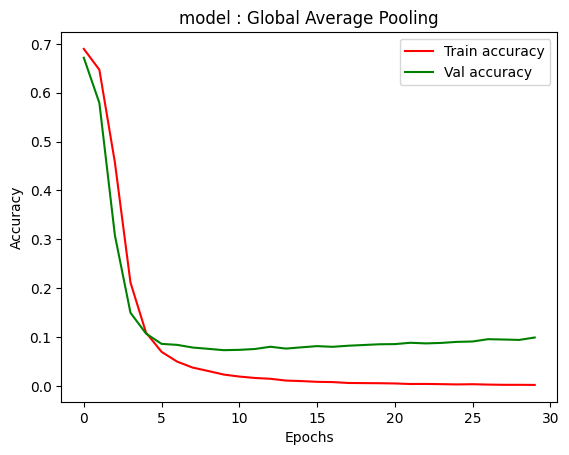

In [46]:
# plot model
# Visualization of the training process on the loss function 
plt.plot(model_GAP.history.history["loss"], color="r", label = "Train accuracy")
plt.plot(model_GAP.history.history["val_loss"], color="g", label='Val accuracy')
plt.gca().set(title='Loss',xlabel='Epochs',ylabel='Accuracy')
plt.title("model : Global Average Pooling")
plt.legend()
plt.show()

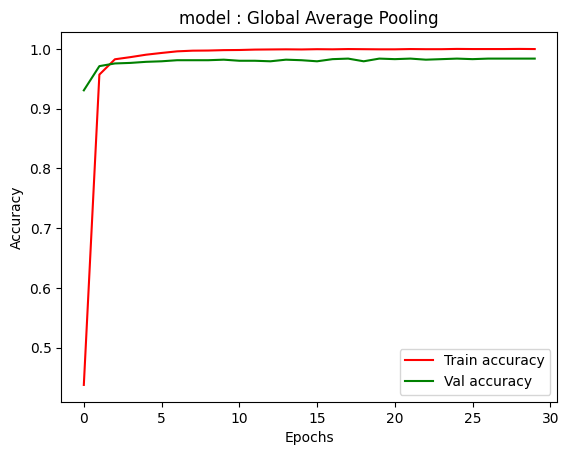

In [47]:
plt.plot(model_GAP.history.history["sparse_categorical_accuracy"], color="r", label='Train accuracy')
plt.plot(model_GAP.history.history["val_sparse_categorical_accuracy"], color="g", label='Val accuracy')
plt.gca().set(title='Accuracy',xlabel='Epochs',ylabel='Accuracy')
plt.title("model : Global Average Pooling")
plt.legend()
plt.show()

Le modèle n'a besoin que de quelques époques pour atteindre une bonne performance et commence à être stable après l'époque 5.

In [49]:
# Faisons quelques predictions

yp_val = model_GAP.predict(xval)
print(classification_report(yval, yp_val.argmax(axis=1)))

35/35 [==============================] - 0s 700us/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       962
           1       0.99      0.89      0.94       149

    accuracy                           0.98      1111
   macro avg       0.98      0.95      0.96      1111
weighted avg       0.98      0.98      0.98      1111



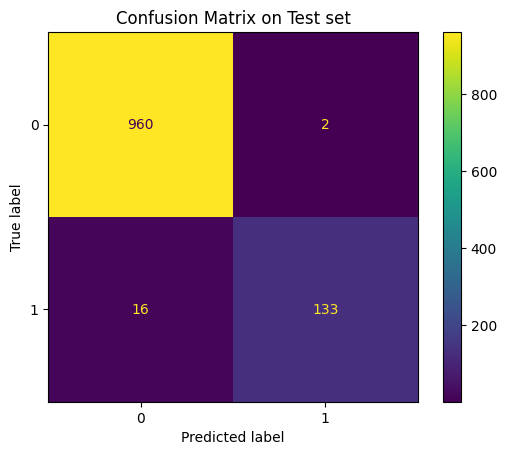

In [50]:
# plot
_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_predictions(yval, yp_val.argmax(axis=1), ax=ax)
plt.show(ax)

On constate que le modele plutôt bien.
Le modèle n'a échoué que 16 fois pour identifier un spam et échoue 2 fois en identifiant un ham comme spam. Les performances sont bonnes, mais nous devons être sûrs que les messages seront conservés dans la boîte de courrier indésirable et non détruits.

In [ ]:
# On sauvegarde le modèle
# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
# format de sauvegarde : Soit 'tf' ou 'h5'. Un chemin de fichier se terminant par '.h5' ou '.keras' sera par défaut HDF5 si save_format est None. Sinon, aucun par défaut est 'tf'.
model_GAP.save("models/model_GAP.h5")